In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss
from sklearn import tree
from sklearn import linear_model
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import sys,os
import seaborn as sns
%matplotlib inline

In [2]:
#reading in training data
training_data = pd.read_csv("/Users/vishaladdala/Desktop/TITANIC/dataset/train.csv")
training_data.sample(15)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
853,854,1,1,"Lines, Miss. Mary Conover",female,16.00,0,1,PC 17592,39.4000,D28,S
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.00,3,2,347088,27.9000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.0000,B42,S
788,789,1,3,"Dean, Master. Bertram Vere",male,1.00,1,2,C.A. 2315,20.5750,NaN,S
607,608,1,1,"Daniel, Mr. Robert Williams",male,27.00,0,0,113804,30.5000,NaN,S
96,97,0,1,"Goldschmidt, Mr. George B",male,71.00,0,0,PC 17754,34.6542,A5,C
571,572,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.00,2,0,11769,51.4792,C101,S
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,NaN,C
590,591,0,3,"Rintamaki, Mr. Matti",male,35.00,0,0,STON/O 2. 3101273,7.1250,NaN,S


In [3]:
#training data statistics using .describe()
training_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
#Feature Transformations
#method to convert ages to bins called 'Unknown'for [-1,0], 'Baby' for [0-5],
#'Child' for [6-12], 'Teenager' for [13-19], 'Student' for [20-25], 'Young Adult' for [26-35], 'Adult' for [36-60],
#'Senior' for [61-100]
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 19, 25, 35, 60, 100)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

In [5]:
#method which simplifies the cabin feature by filling N/A values with 'N'
#also it takes only the first letter the cabin using splicing
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

In [6]:
#method to convert fares into bins using the numbers from .descrobe() statistics earlier
#the N/A values are filled with -0.5
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

In [7]:
#Feature Extraction 
#the below method is used to extract two features from the Name column
#method to format the Name column to extract LName and NamePrefix
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df      

In [8]:
#method to drop the features which we inconsider inconsequential
#we have selected ticket,Name,Embarked columns to be dropped due lack of variance or too many N/A values
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)


In [9]:
#this method calls all the above transformation methods one by one and applies it on our dataframe
def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

In [10]:
#Now we proceed to proceed to apply the transformations on the training data
transformed_train = transform_features(training_data)
transformed_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


In [11]:
#as we can see above our training data now has :
#1. LName, NamePrefix instead of 'Name' which has been dropped
#2. 'Ticket', 'Name', 'Embarked' have been dropped 
#3. 'Fare', 'Age' have been converted into convenient bins

In [12]:
#Now we proceed to apply the above feature transformations on the test data
test_data = pd.read_csv("/Users/vishaladdala/Desktop/TITANIC/dataset/test.csv")
test_data.sample(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
207,1099,2,"Collett, Mr. Sidney C Stuart",male,24.0,0,0,28034,10.5000,NaN,S
343,1235,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",female,58.0,0,1,PC 17755,512.3292,B51 B53 B55,C
405,1297,2,"Nourney, Mr. Alfred (Baron von Drachstedt"")""",male,20.0,0,0,SC/PARIS 2166,13.8625,D38,C
212,1104,2,"Deacon, Mr. Percy William",male,17.0,0,0,S.O.C. 14879,73.5000,NaN,S
13,905,2,"Howard, Mr. Benjamin",male,63.0,1,0,24065,26.0000,NaN,S


In [13]:
transformed_test = transform_features(test_data)
transformed_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,male,Young Adult,0,0,1_quartile,N,"Kelly,",Mr.
1,893,3,female,Adult,1,0,1_quartile,N,"Wilkes,",Mrs.
2,894,2,male,Senior,0,0,2_quartile,N,"Myles,",Mr.
3,895,3,male,Young Adult,0,0,2_quartile,N,"Wirz,",Mr.
4,896,3,female,Student,1,1,2_quartile,N,"Hirvonen,",Mrs.


In [14]:
#Now as a next step, we need to remember that machine learning algorithms need all the input to be numerical values
#But as we can observe from above 'Sex', 'Age' , 'Fare', 'Cabin', 'Lname', 'NamePrefix' are in nominal(string) format
#Hence we need to convert these into numerical values

In [15]:
#Here we proceed to use LabelEncoder from sklearn preprocessing to achieve 
#Every column in numerical form
from sklearn import preprocessing
def encode_features(df_train, df_test):
    features = ['Fare', 'Cabin', 'Age', 'Sex', 'Lname', 'NamePrefix']
    df_combined = pd.concat([df_train[features], df_test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df_train[feature] = le.transform(df_train[feature])
        df_test[feature] = le.transform(df_test[feature])
    return df_train, df_test
    
data_train, data_test = encode_features(transformed_train, transformed_test)
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,1,4,1,0,0,7,100,19
1,2,1,1,0,0,1,0,3,2,182,20
2,3,1,3,0,7,0,0,0,7,329,16
3,4,1,1,0,7,1,0,3,2,267,20
4,5,0,3,1,7,0,0,1,7,15,19


In [16]:
data_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,892,3,1,7,0,0,0,7,401,19
1,893,3,0,0,1,0,0,7,843,20
2,894,2,1,3,0,0,1,7,552,19
3,895,3,1,7,0,0,1,7,851,19
4,896,3,0,4,1,1,1,7,342,20


In [17]:
#Now we proceed to test the various classifiers in Scikit-Learn to 
#see which classifiers works best on our data

In [18]:
#Below we are splitting up our training data into 80% training , 20% testing data 
# X contains all the columns except 'Survived' because that is the feature we predict
# Y consists only of the column 'Survived'
X = data_train.drop(['Survived'], axis=1)
Y = data_train.Survived
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


In [19]:
#Our first classifier will be Decision Tree
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
Y_pred =  dtree.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

[[96 15]
 [22 46]]
0.793296089385


In [20]:
# Artifical Neural Network
classifiers = {}
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100), max_iter = 1000,alpha = 0.01, momentum = 0.7)
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Artificial Nueral Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NN"]=clf

Artificial Nueral Network:
0.542117706237  -  0.577236194947


In [21]:
#Deep Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100,100,100), max_iter = 100,alpha = 0.3, momentum = 0.7,activation = "relu")
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Deep Neural Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["DNN"]=clf

Deep Neural Network:
0.505573999553  -  0.578625083836


In [22]:
#Support Vector Machine
clf = svm.SVC()
clf.set_params(C = 100, kernel = "rbf")
svm_clf = clf.fit(X_train,Y_train)
svm_predict = svm_clf.predict(X_test)
svm_acc = accuracy_score(Y_test,svm_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Support Vector Machines:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["SVM"]=clf

Support Vector Machines:
0.618025933378  -  0.618025933378


In [23]:
#Multinomial Naive Bayes
clf = MultinomialNB()
clf.set_params(alpha = 0.1)
nb_clf = clf.fit(X_train,Y_train)
nb_predict = nb_clf.predict(X_test)
nb_acc = accuracy_score(Y_test,nb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Multinomial Naive Bayes:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NB"]=clf

Multinomial Naive Bayes:
0.533551307847  -  0.533551307847


In [24]:
#Logistic Regression
clf = LogisticRegression()
clf.set_params(C = 10, max_iter = 10)
lr_clf = clf.fit(X_train,Y_train)
lr_predict = lr_clf.predict(X_test)
lr_acc = accuracy_score(Y_test,lr_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Logistic Regression:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["LR"]=clf

Logistic Regression:
0.681056338028  -  0.681056338028


In [25]:
#k-NN Classifier
clf = KNeighborsClassifier()
clf.set_params(n_neighbors= 5,leaf_size = 30)
knn_clf = clf.fit(X_train,Y_train)
knn_predict = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test,knn_predict)
param =  knn_clf.get_params()
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("k-NN :")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["KNN"]=clf

k-NN :
0.563109769729  -  0.563109769729


In [26]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["RF"]=clf

Random Forest Classifier:
0.821282696177  -  0.825528727923


In [27]:
#AdaBoost
clf = AdaBoostClassifier()
clf.set_params(n_estimators = 10, learning_rate = 1)
ada_clf = clf.fit(X_train,Y_train)
ada_predict = ada_clf.predict(X_test)
ada_acc = accuracy_score(Y_test,ada_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("AdaBoost:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["ADA"]=clf

AdaBoost:
0.800313547954  -  0.800313547954


In [28]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf.set_params(n_estimators = 30,learning_rate = 1)
gb_clf = clf.fit(X_train,Y_train)
gb_predict = gb_clf.predict(X_test)
gb_acc = accuracy_score(Y_test,gb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("GradientBoostingClassifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["GB"]=clf


GradientBoostingClassifier:
0.800587413369  -  0.793545159848


In [29]:
#Perceptron
clf = linear_model.Perceptron()
#clf.set_params(max_iter = 1000,alpha = 0.01)
pt_clf = clf.fit(X_train,Y_train)
pt_predict = pt_clf.predict(X_test)
pt_acc = accuracy_score(Y_test,pt_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Perceptron:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["PT"]=clf

Perceptron:
0.532415045831  -  0.532415045831


In [30]:
#Here we print the performance of the various classifiers
print ("accuracy","              ","F-score")
for clf in classifiers.values():
    accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
    f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
    for i in classifiers:
        if classifiers[i]== clf:
            print (i),
            break
    print ( " : ",accuracy.mean(), "  ",f_score.mean())
    

accuracy                F-score
NN
 :  0.581383858708    0.552237871674
DNN
 :  0.516906438632    0.588741895819
SVM
 :  0.618025933378    0.618025933378
NB
 :  0.533551307847    0.533551307847
LR
 :  0.681056338028    0.681056338028
KNN
 :  0.563109769729    0.563109769729
RF
 :  0.819854124748    0.815687458082
ADA
 :  0.800313547954    0.800313547954
GB
 :  0.793565280572    0.794954169461
PT
 :  0.532415045831    0.532415045831


In [31]:
#Hence we see that Random forest classifier gave the best performance with an accuracy ~83% and an F-score ~83%

In [32]:
#Next we proceed to apply "Feature Scaling" to see if the performance of our various classifiers improves
#Feature scaling aims to bring the values of our numerical features between 0 and 1
#This is mainly done because large numerical values may skew our data and make the classifier weight it more 

In [33]:
XX = data_train.drop(['Survived'], axis=1)
YY = data_train.Survived
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
XX[XX.columns] = scaler.fit_transform(XX[XX.columns])

In [34]:
XX.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,0.000000,1.0,1.0,0.571429,0.125,0.0,0.00,0.875,0.115340,0.575758
1,0.001124,0.0,0.0,0.000000,0.125,0.0,0.75,0.250,0.209919,0.606061
2,0.002247,1.0,0.0,1.000000,0.000,0.0,0.00,0.875,0.379469,0.484848
3,0.003371,0.0,0.0,1.000000,0.125,0.0,0.75,0.250,0.307958,0.606061
4,0.004494,1.0,1.0,1.000000,0.000,0.0,0.25,0.875,0.017301,0.575758


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


In [36]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
Y_pred =  dtree.predict(X_test)
print(confusion_matrix(Y_test,Y_pred))
print(accuracy_score(Y_test,Y_pred))

[[96 15]
 [26 42]]
0.77094972067


In [37]:
# Artifical Neural Network
classifiers = {}
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100), max_iter = 1000,alpha = 0.01, momentum = 0.7)
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Artificial Nueral Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NN"]=clf

Artificial Nueral Network:
0.790273865415  -  0.790353230494


In [38]:
#Deep Neural Network
clf = MLPClassifier()
clf.set_params(hidden_layer_sizes =(100,100,100,100), max_iter = 100,alpha = 0.3, momentum = 0.7,activation = "relu")
nn_clf = clf.fit(X_train,Y_train)
nn_predict = nn_clf.predict(X_test)
nn_acc = accuracy_score(Y_test,nn_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Deep Neural Network:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["DNN"]=clf

Deep Neural Network:
0.783290856249  -  0.798705007825


In [39]:
#Support Vector Machine
clf = svm.SVC()
clf.set_params(C = 100, kernel = "rbf")
svm_clf = clf.fit(X_train,Y_train)
svm_predict = svm_clf.predict(X_test)
svm_acc = accuracy_score(Y_test,svm_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Support Vector Machines:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["SVM"]=clf

Support Vector Machines:
0.79598759222  -  0.79598759222


In [40]:
#Multinomial Naive Bayes
clf = MultinomialNB()
clf.set_params(alpha = 0.1)
nb_clf = clf.fit(X_train,Y_train)
nb_predict = nb_clf.predict(X_test)
nb_acc = accuracy_score(Y_test,nb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Multinomial Naive Bayes:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["NB"]=clf

Multinomial Naive Bayes:
0.734225911022  -  0.734225911022


In [41]:
#Logistic Regression
clf = LogisticRegression()
clf.set_params(C = 10, max_iter = 10)
lr_clf = clf.fit(X_train,Y_train)
lr_predict = lr_clf.predict(X_test)
lr_acc = accuracy_score(Y_test,lr_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Logistic Regression:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["LR"]=clf

Logistic Regression:
0.79590878605  -  0.79590878605


In [42]:
#k-NN Classifier
clf = KNeighborsClassifier()
clf.set_params(n_neighbors= 5,leaf_size = 30)
knn_clf = clf.fit(X_train,Y_train)
knn_predict = knn_clf.predict(X_test)
knn_acc = accuracy_score(Y_test,knn_predict)
param =  knn_clf.get_params()
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("k-NN :")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["KNN"]=clf

k-NN :
0.781843281914  -  0.781843281914


In [43]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["RF"]=clf

Random Forest Classifier:
0.822691146881  -  0.828464676951


In [44]:
#AdaBoost
clf = AdaBoostClassifier()
clf.set_params(n_estimators = 10, learning_rate = 1)
ada_clf = clf.fit(X_train,Y_train)
ada_predict = ada_clf.predict(X_test)
ada_acc = accuracy_score(Y_test,ada_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("AdaBoost:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["ADA"]=clf

AdaBoost:
0.800313547954  -  0.800313547954


In [45]:
#Gradient Boosting Classifier
clf = GradientBoostingClassifier()
clf.set_params(n_estimators = 30,learning_rate = 1)
gb_clf = clf.fit(X_train,Y_train)
gb_predict = gb_clf.predict(X_test)
gb_acc = accuracy_score(Y_test,gb_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("GradientBoostingClassifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["GB"]=clf

GradientBoostingClassifier:
0.797790073776  -  0.799218645205


In [46]:
#Perceptron
clf = linear_model.Perceptron()
#clf.set_params(max_iter = 1000,alpha = 0.01)
pt_clf = clf.fit(X_train,Y_train)
pt_predict = pt_clf.predict(X_test)
pt_acc = accuracy_score(Y_test,pt_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Perceptron:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["PT"]=clf

Perceptron:
0.72692432372  -  0.72692432372


In [47]:
#Here we print the performance of the various classifiers after feature scaling
print ("accuracy","              ","F-score")
for clf in classifiers.values():
    accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
    f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
    for i in classifiers:
        if classifiers[i]== clf:
            print (i),
            break
    print ( " : ",accuracy.mean(), "  ",f_score.mean())
    

accuracy                F-score
NN
 :  0.784778672032    0.798825732171
DNN
 :  0.798786049631    0.80160295104
SVM
 :  0.79598759222    0.79598759222
NB
 :  0.734225911022    0.734225911022
LR
 :  0.79590878605    0.79590878605
KNN
 :  0.781843281914    0.781843281914
RF
 :  0.81711602951    0.824218645205
ADA
 :  0.800313547954    0.800313547954
GB
 :  0.790767940979    0.793604963112
PT
 :  0.72692432372    0.72692432372


In [48]:
#Here we see the performance of various classifiers has improved dramatically after feature 
#But we see that Random Forest still is our best performing classifier

In [49]:
#Trying the concept of hyperparameter tuning using grid search

In [55]:
#Support Vector Machine

#clf = svm.SVC()
#clf.set_params(C = 100, kernel = "rbf")
#svm_clf = clf.fit(X_train,Y_train)
#svm_predict = svm_clf.predict(X_test)
#svm_acc = accuracy_score(Y_test,svm_predict)
#accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
#f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
#print("Support Vector Machines:")
#print (accuracy.mean(), " - ",f_score.mean())
#classifiers["SVM"]=clf
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.75, random_state = 5)

from __future__ import print_function
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train,Y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = Y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()













# Tuning hyper-parameters for precision



/Users/vishaladdala/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vishaladdala/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vishaladdala/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/vishaladdala/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_f

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.322 (+/-0.005) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.322 (+/-0.005) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.322 (+/-0.005) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.322 (+/-0.005) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.713 (+/-0.103) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.322 (+/-0.005) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.698 (+/-0.084) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.713 (+/-0.103) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.703 (+/-0.092) for {'C': 1, 'kernel': 'linear'}
0.681 (+/-0.088) for {'C': 10, 'kernel': 'linear'}
0.681 (+/-0.088) for {'C': 100, 'kernel': 'linear'}
0.681 (+/-0.088) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

            

In [59]:
clf = svm.SVC()
clf.set_params(C = 100, kernel = "rbf", gamma= 0.001)
svm_clf = clf.fit(X_train,Y_train)
svm_predict = svm_clf.predict(X_test)
svm_acc = accuracy_score(Y_test,svm_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Support Vector Machines:")
print (accuracy.mean(), " - ",f_score.mean())

Support Vector Machines:
0.728722002635  -  0.728722002635


In [65]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


X, y = X_train,Y_train

# build a classifier
clf = RandomForestClassifier(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3,10, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

RandomizedSearchCV took 2.23 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.725 (std: 0.036)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 1, 'min_samples_split': 4}

Model with rank: 2
Mean validation score: 0.721 (std: 0.063)
Parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 10}

Model with rank: 2
Mean validation score: 0.721 (std: 0.048)
Parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 6, 'min_samples_leaf': 5, 'min_samples_split': 5}

GridSearchCV took 33.71 seconds for 324 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.734 (std: 0.035)
Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 3, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.734 (s

In [67]:
#Model with rank: 1
#Mean validation score: 0.734 (std: 0.028)
#Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 4, 'min_samples_split': 6}

#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10, max_features = 3, criterion = 'entropy')
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())
classifiers["RF"]=clf

Random Forest Classifier:
0.706192358366  -  0.723800112931


In [68]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())

Random Forest Classifier:
0.70146809712  -  0.720280444193


In [69]:
XX.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,0.000000,1.0,1.0,0.571429,0.125,0.0,0.00,0.875,0.115340,0.575758
1,0.001124,0.0,0.0,0.000000,0.125,0.0,0.75,0.250,0.209919,0.606061
2,0.002247,1.0,0.0,1.000000,0.000,0.0,0.00,0.875,0.379469,0.484848
3,0.003371,0.0,0.0,1.000000,0.125,0.0,0.75,0.250,0.307958,0.606061
4,0.004494,1.0,1.0,1.000000,0.000,0.0,0.25,0.875,0.017301,0.575758


In [70]:
YY.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [71]:
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.20, random_state = 5)



In [72]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10)
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())

Random Forest Classifier:
0.825528169014  -  0.825548848647


In [75]:
#Random Forest Classifier
clf = RandomForestClassifier()
clf.set_params(n_estimators = 100, max_depth = 10, max_features = 3, criterion = 'entropy')
rf_clf = clf.fit(X_train,Y_train)
rf_predict = rf_clf.predict(X_test)
rf_acc = accuracy_score(Y_test,rf_predict)
accuracy = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'accuracy')
f_score = cross_val_score(clf, X_train , Y_train, cv=10,scoring = 'f1_micro')
print("Random Forest Classifier:")
print (accuracy.mean(), " - ",f_score.mean())


Random Forest Classifier:
0.817077464789  -  0.832610663984


/Users/vishaladdala/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ROC AUC: 0.87


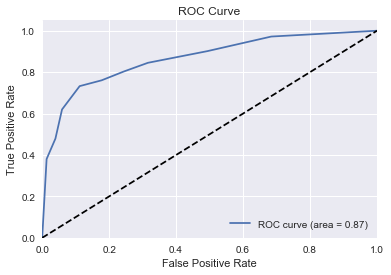

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
 
# shuffle and split training and test sets
#X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size = 0.20, random_state = 5)
X_train, X_test, Y_train, Y_test = train_test_split(XX, YY, test_size=.25)

forest = RandomForestClassifier()
#clf.set_params(n_estimators = 100, max_depth = 10, max_features = 3, criterion = 'gini')
#rf_clf = clf.fit(X_train,Y_train)
#rf_predict = rf_clf.predict(X_test)

forest.fit(X_train, Y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(Y_test, forest.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print ('ROC AUC: %0.2f' % roc_auc)
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()